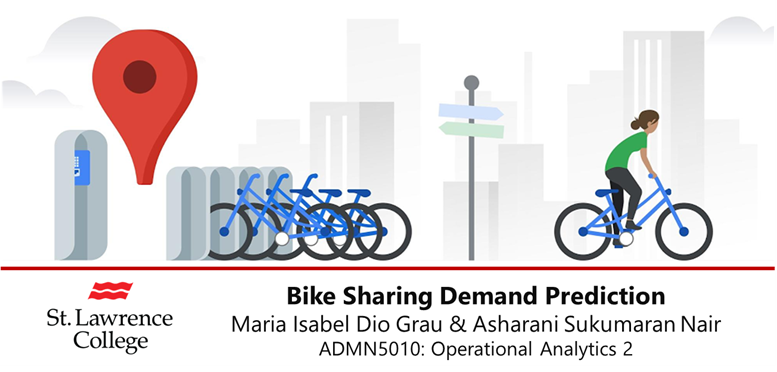

<i>This Python notebook contains a combination of markdown text and code block comments that explain the tasks being executed.</i><br>
***

### Client background and dataset description
Because of the COVID-19 pandemic, bike-sharing company, BoomBikes, suffered a decline in revenue. Recognizing that it may take a while to recover from the economic downturn, the company would like to develop a machine learning model that can predict demand for bikes based on several factors.

The company was able to gather data on their daily bike demand from 2018-2019 - a total of 730 observations. This dataset also includes several factors that could have affected these demand levels, such as temperature, humidity, windspeed, and even time (year, month, weekday, etc.).

The following script can be broken down into the following steps (each line is linked to the code block that executes the corresponding step):
1. <a href='#extract'>Extract dataset from GitHub</a>
2. <a href='#data'>Data exploration and data cleaning</a>
3. <a href='#regression'>Demand prediction</a>

Data Source: https://www.kaggle.com/datasets/yasserh/bike-sharing-dataset
***
Before running the program, packages must first be imported in order to access the various functions used by the codes below. If necessary, the packages must first be installed with `pip install [package name]`

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

<a id='extract'></a>
### Extract datasets from GitHub

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/isabelgrau/ADMN5010-Operational-Analytics/main/bikesharing.csv")

In [4]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


<a id='data'></a>
### Data exploration and data cleaning

For consistency and to identify possible trends related to the day of the month, a new column - ```day``` - will be added.

In [5]:
df.insert(5, 'day', df['dteday'].apply(lambda x: x[0:2]))
df.head()

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,01,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,02,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,03,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,04,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,05,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [6]:
# Check tail if day column is correct

df.tail()

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
725,726,27-12-2019,1,1,12,27,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,28,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,29,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,30,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796
729,730,31-12-2019,1,1,12,31,0,1,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729


In [7]:
print("The dataset contains " + str(df.shape[0]) + " observations and " + str(df.shape[1]) + " columns.")

The dataset contains 730 observations and 17 columns.


However, not all columns are features. Some are either correlated with each other or have no predictive power. The following columns will be dropped from the dataset:
- <b>instant</b> - ID; no predictive power; unnecessary since the dataframe already has an index
- <b>season</b> - correlated with month
- <b>atemp</b> - correlated with temp
- <b>casual and registered</b> - sum of casual and registered is cnt (This would help if the company's products differed between casual and registered bikers. However, the dataset does not specify the difference between the two, so these will be dropped.)

In [8]:
df = df.drop(['instant', 'season', 'atemp', 'casual', 'registered'], axis = 1)
df.head()

,dteday,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,01-01-2018,0,1,01,0,6,0,2,14.110847,80.5833,10.749882,985
1,02-01-2018,0,1,02,0,0,0,2,14.902598,69.6087,16.652113,801
2,03-01-2018,0,1,03,0,1,1,1,8.050924,43.7273,16.636703,1349
3,04-01-2018,0,1,04,0,2,1,1,8.200000,59.0435,10.739832,1562
4,05-01-2018,0,1,05,0,3,1,1,9.305237,43.6957,12.522300,1600


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   day         730 non-null    object 
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 68.6+ KB


The following columns will be typecasted to accurately reflect their data type:
- <b>dtetype</b> - from object to datetime
- <b>day</b> - from object to int

Although columns 2-8 (from yr to weathersit) are categorical, this analysis will continue to use the int64 data type to simplify the regression model parameters.

In [10]:
df['dteday'] = pd.to_datetime(df['dteday'], format='%d-%m-%Y')
df['day'] = df['day'].astype('int64')
df.head()

,dteday,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,2018-01-01,0,1,1,0,6,0,2,14.110847,80.5833,10.749882,985
1,2018-01-02,0,1,2,0,0,0,2,14.902598,69.6087,16.652113,801
2,2018-01-03,0,1,3,0,1,1,1,8.050924,43.7273,16.636703,1349
3,2018-01-04,0,1,4,0,2,1,1,8.200000,59.0435,10.739832,1562
4,2018-01-05,0,1,5,0,3,1,1,9.305237,43.6957,12.522300,1600


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      730 non-null    datetime64[ns]
 1   yr          730 non-null    int64         
 2   mnth        730 non-null    int64         
 3   day         730 non-null    int64         
 4   holiday     730 non-null    int64         
 5   weekday     730 non-null    int64         
 6   workingday  730 non-null    int64         
 7   weathersit  730 non-null    int64         
 8   temp        730 non-null    float64       
 9   hum         730 non-null    float64       
 10  windspeed   730 non-null    float64       
 11  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 68.6 KB


In [12]:
# Check for null values

df.isnull().sum()

dteday        0
yr            0
mnth          0
day           0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
hum           0
windspeed     0
cnt           0
dtype: int64

There are no null values in the dataset.

In [13]:
# Get statistics of numeric columns
num_columns = ['temp', 'hum', 'windspeed', 'cnt']
df[num_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
temp,730.0,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
hum,730.0,62.765175,14.237589,0.000000,52.000000,62.625000,72.989575,97.250000
windspeed,730.0,12.763620,5.195841,1.500244,9.041650,12.125325,15.625589,34.000021
cnt,730.0,4508.006849,1936.011647,22.000000,3169.750000,4548.500000,5966.000000,8714.000000


Over the two-year period, demand ranged from as low as 22 bikes to 8,714 bikes, with an average of 4,508. This large variance emphasizes the need for the company to develop an accurate prediction model in order to meet demand.

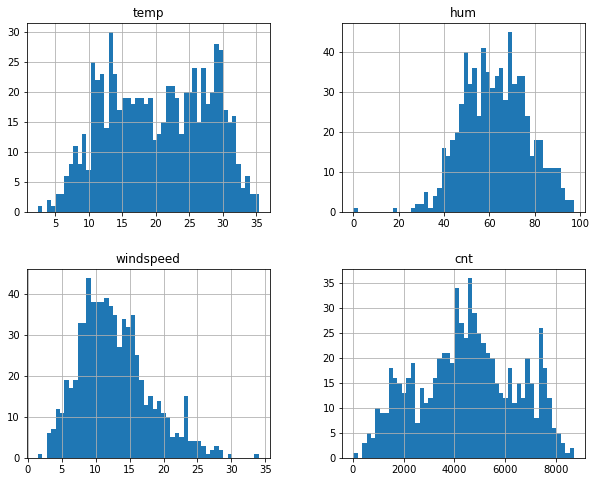

In [14]:
df[num_columns].hist(bins=50, figsize=(10,8))
plt.show()

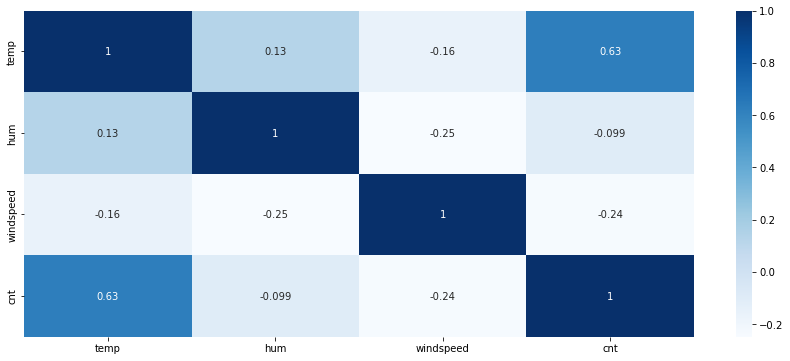

In [15]:
# Create a correlation heatmap

plt.figure(figsize=(15,6))
heatmap = sns.heatmap(df[num_columns].corr(), annot=True, cmap="Blues")

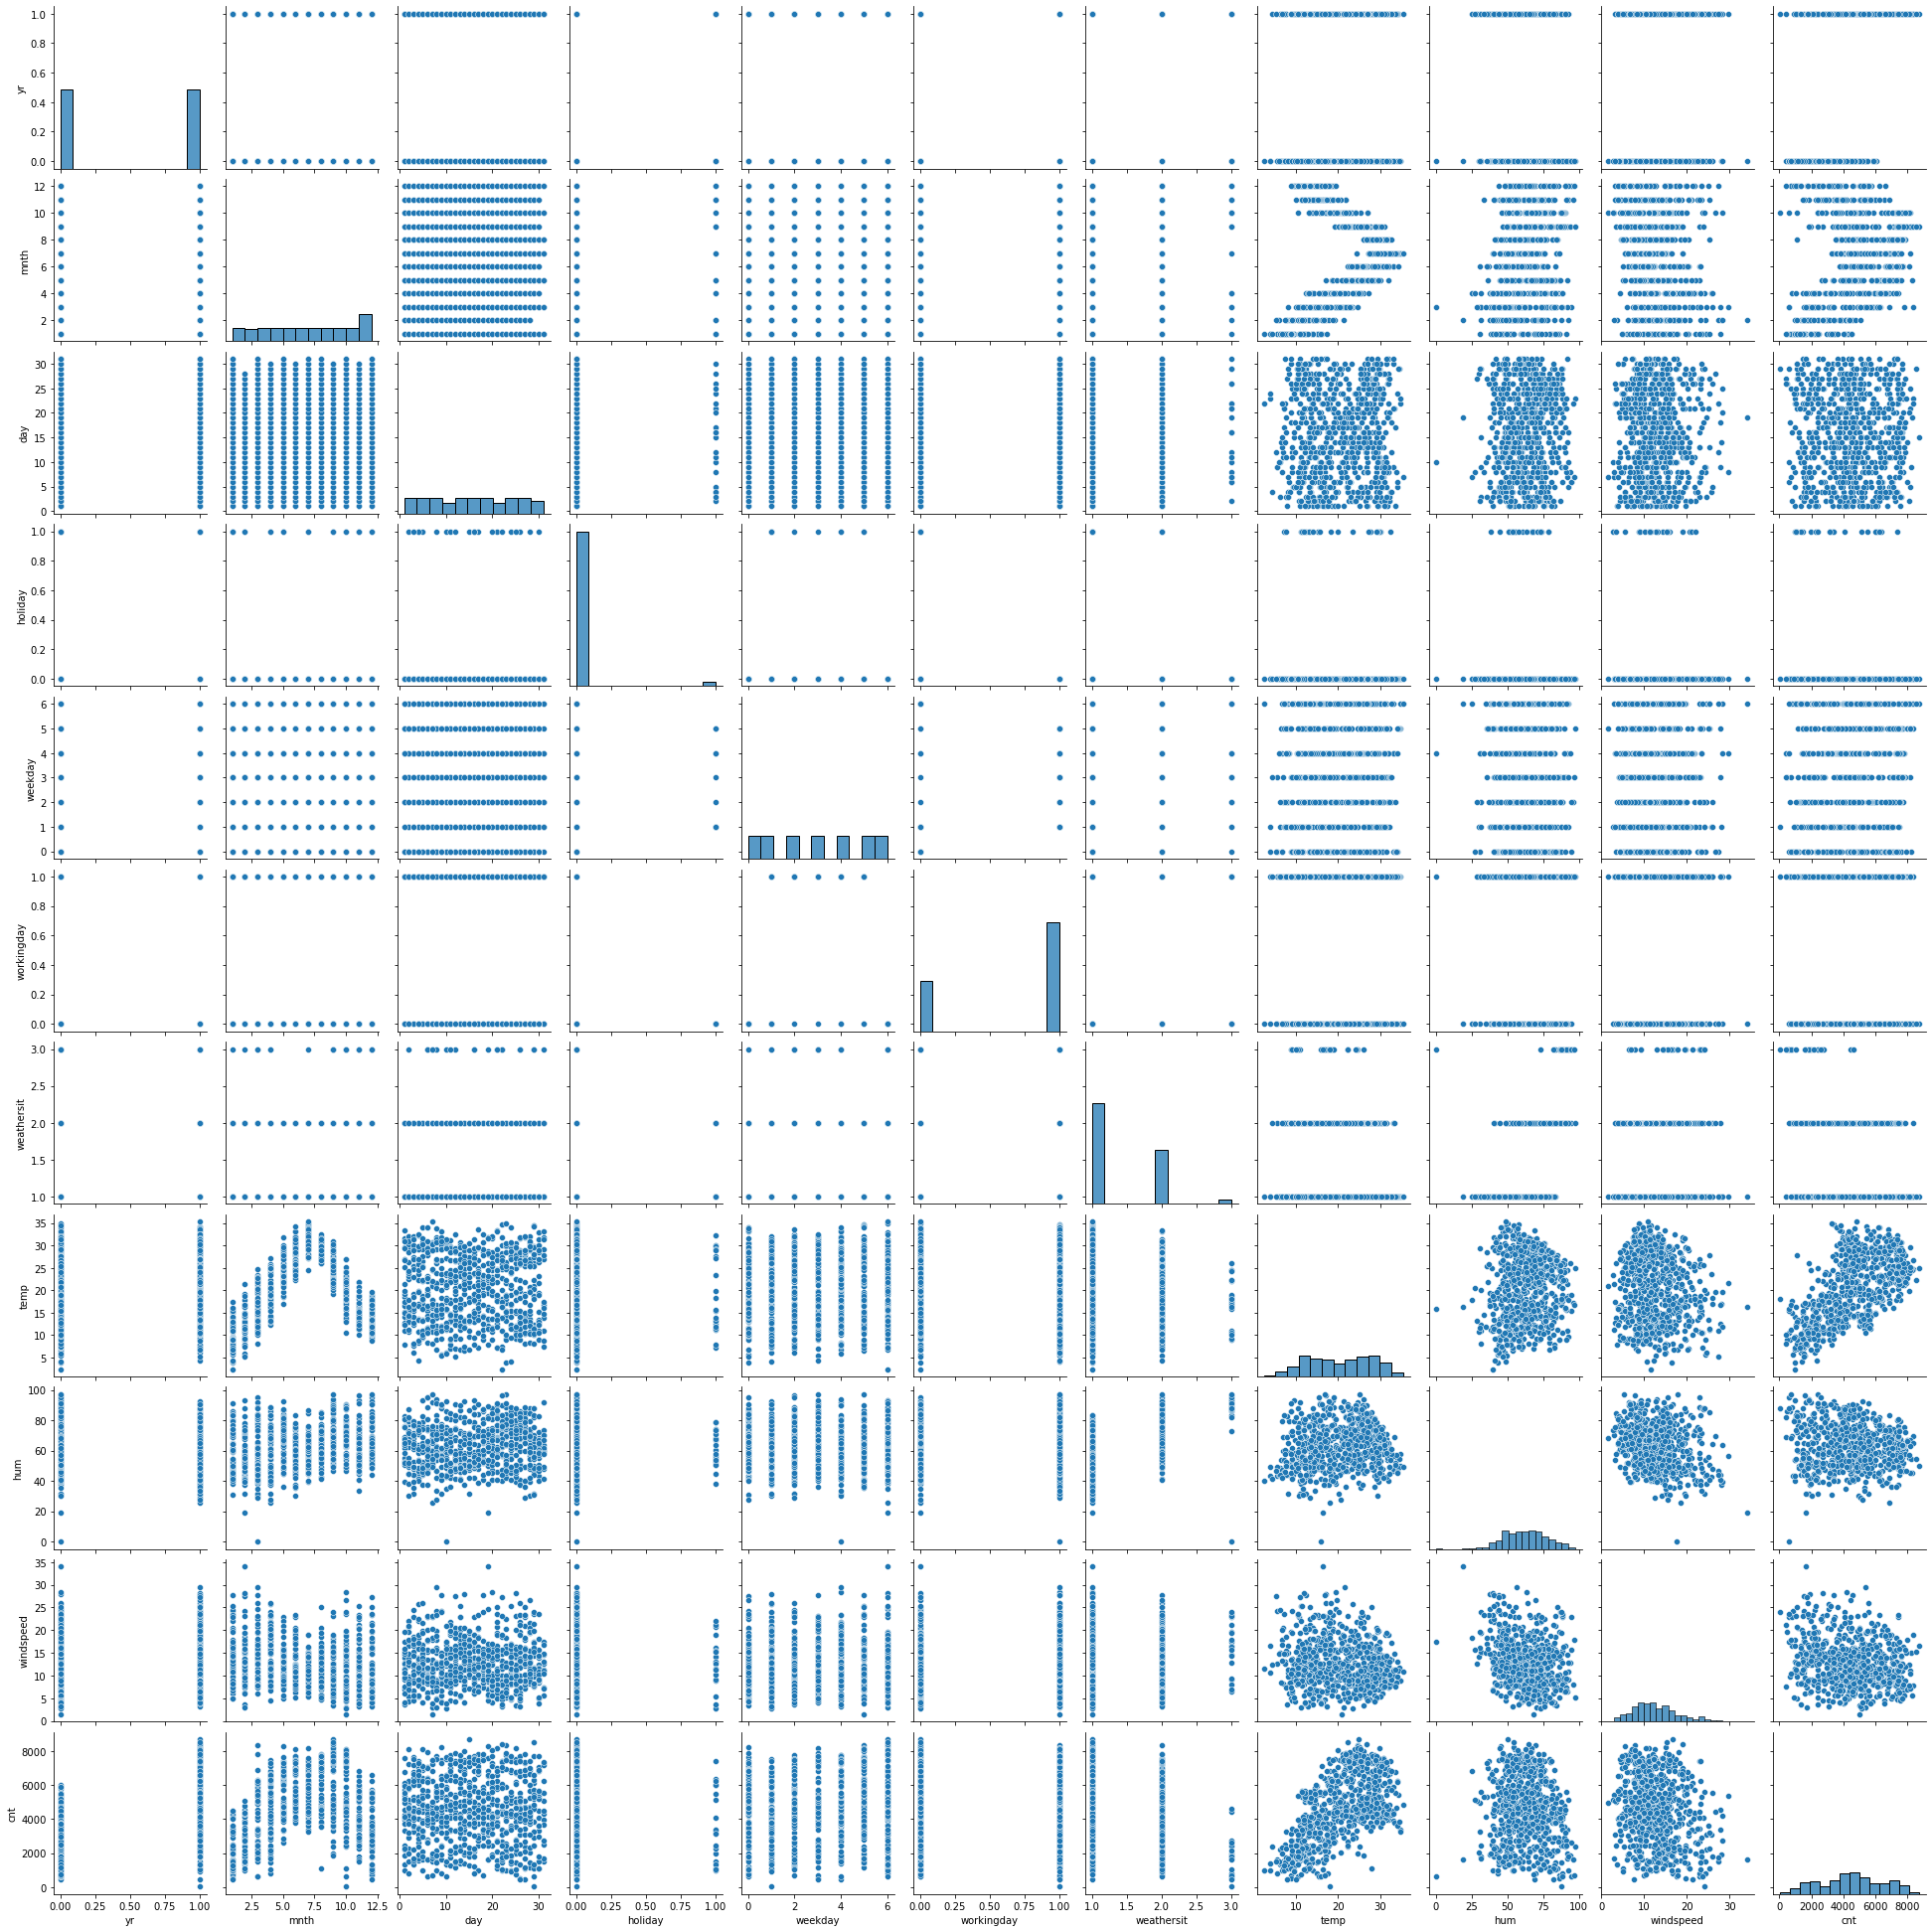

In [16]:
sns.pairplot(df)

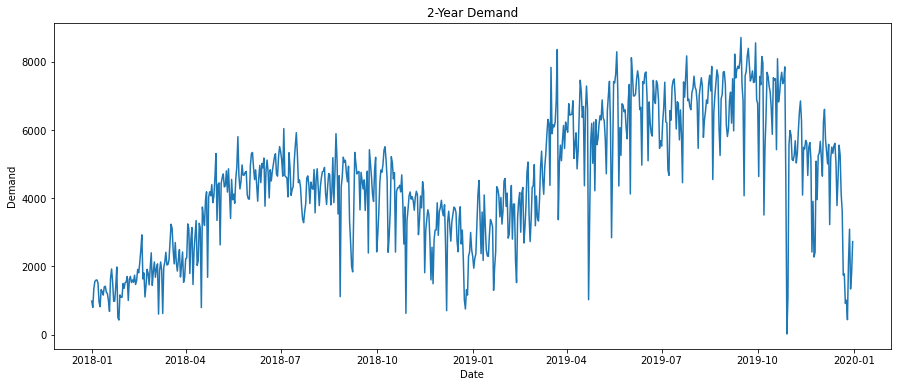

In [17]:
plt.figure(figsize=(15,6))
plt.plot(df['dteday'],df['cnt'])
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('2-Year Demand')
plt.show()

The following observations can be made from the correlation matrix, scatterplots, and line chart:
- Demand is positively correlated with temperature. Demand is higher when temperature is warmer.
- There is no strong correlation between demand and both humidity and windspeed.
- There is an upward trend in annual demand.
- Demand is highest in the middle of the year.
- Demand is high when the weather situation is 1 (clear weather) and low when the situation is 3 (heavy rain, fog, thunderstorm).
- Although the scatterplot shows that demand is higher when it is not a holiday, there were only a few holidays during the period. There is not enough data to infer a relationship between holidays and demand.
- There is no relationship between demand and both weekday and working day.

<a id='regression'></a>
### Demand prediction

Demand prediction will be broken down into two cases, based on the features used as predictors, to ensure that the best model is selected.

#### Case 1: Drop the date column. Use year, month, and day.

In [18]:
# Create traning and testing datasets

x1 = df.drop(['dteday', 'cnt'], axis = 1)
y1 = df['cnt']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=0)

In [19]:
# Identify the best model

regressors = {
    "LinearRegression": LinearRegression(),
    "XGBRegressor": XGBRegressor(silent=True),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "TheilSenRegressor": TheilSenRegressor(),
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
}

In [20]:
df_models_1 = pd.DataFrame(columns=['model', 'run_time', 'RMSE', 'MAPE', 'R2'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(x1_train, y1_train)
    y1_pred = model.predict(x1_test)

    scores = cross_val_score(model, 
                             x1_train, 
                             y1_train,
                             scoring="neg_mean_squared_error", 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'RMSE': round(np.sqrt(mean_squared_error(y1_test, y1_pred))),
           'MAPE': round(mean_absolute_percentage_error(y1_test, y1_pred)*100,2),
           'R2' : round(r2_score(y1_test, y1_pred)*100,2)
    }

    df_models_1 = df_models_1.append(row, ignore_index=True)

* LinearRegression
* XGBRegressor
[12:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not

In [21]:
# Order model results

df_models_1.head(20).sort_values(by='RMSE', ascending=True)

,model,run_time,RMSE,MAPE,R2
1,XGBRegressor,0.03,721,19.34,87.6
2,RandomForestRegressor,0.04,743,21.02,86.84
0,LinearRegression,0.0,947,24.02,78.61
8,Lars,0.0,947,24.02,78.61
7,Ridge,0.0,949,24.1,78.53
13,BayesianRidge,0.0,951,24.18,78.45
12,ARDRegression,0.0,955,24.56,78.25
3,DecisionTreeRegressor,0.0,959,26.14,78.08
9,TheilSenRegressor,0.09,968,25.6,77.66
10,HuberRegressor,0.01,980,25.67,77.11


#### Case 2: Drop the year, month, and day columns. Use date.

In [22]:
# Create traning and testing datasets

df['dteday'] = df['dteday'].map(dt.datetime.toordinal)

x2 = df.drop(['yr', 'mnth', 'day', 'cnt'], axis = 1)
y2 = df['cnt']

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.3, random_state=0)

In [23]:
# Identify the best model

regressors = {
    "LinearRegression": LinearRegression(),
    "XGBRegressor": XGBRegressor(silent=True),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "TheilSenRegressor": TheilSenRegressor(),
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
}

In [24]:
df_models_2 = pd.DataFrame(columns=['model', 'run_time', 'RMSE', 'MAPE', 'R2'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(x2_train, y2_train)
    y2_pred = model.predict(x2_test)

    scores = cross_val_score(model, 
                             x2_train, 
                             y2_train,
                             scoring="neg_mean_squared_error", 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'RMSE': round(np.sqrt(mean_squared_error(y2_test, y2_pred))),
           'MAPE': round(mean_absolute_percentage_error(y2_test, y2_pred)*100,2),
           'R2' : round(r2_score(y2_test, y2_pred)*100,2)
    }

    df_models_2 = df_models_2.append(row, ignore_index=True)

* LinearRegression
* XGBRegressor
[12:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not

In [25]:
# Order model results

df_models_2.head(20).sort_values(by='RMSE', ascending=True)

,model,run_time,RMSE,MAPE,R2
1,XGBRegressor,0.01,679,17.68,89.02
2,RandomForestRegressor,0.04,691,19.7,88.61
0,LinearRegression,0.0,989,24.83,76.67
8,Lars,0.0,989,24.83,76.67
7,Ridge,0.0,990,24.85,76.65
3,DecisionTreeRegressor,0.0,994,25.94,76.43
12,ARDRegression,0.0,996,25.31,76.34
13,BayesianRidge,0.0,1003,25.57,76.0
14,ElasticNet,0.0,1032,27.0,74.63
15,OrthogonalMatchingPursuit,0.0,1618,48.5,37.6


For both cases, XGBRegressor had the best prediction. Case 2, however, provided a better prediction, with an RMSE of 679, MAPE of 18%, and R^2 of 89%. As such, the case 2 XGBRegressor model will be used on the testing dataset.

In [26]:
# Assess the best model

regressor = XGBRegressor(silent=True)
model = regressor.fit(x2_train, y2_train)
y2_pred = model.predict(x2_test)

[12:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




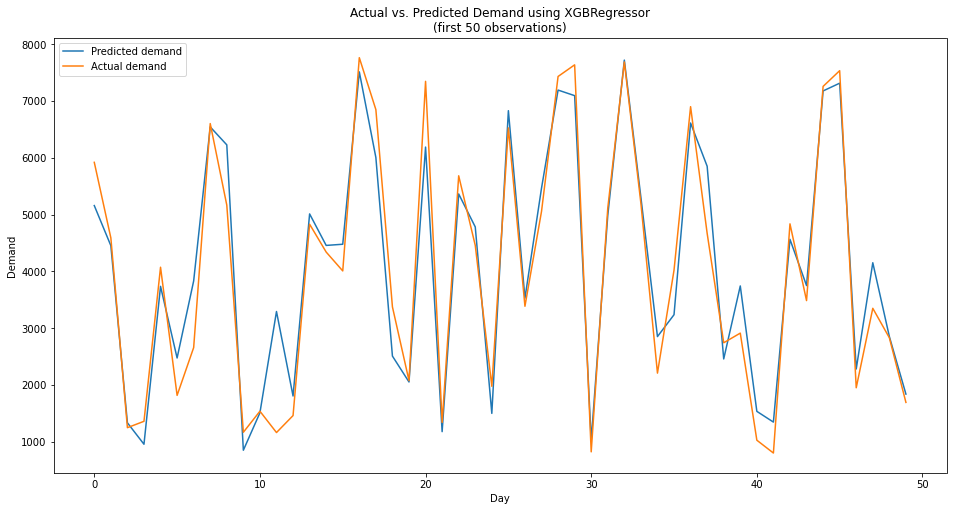

In [27]:
# Plot

test = pd.DataFrame({'Predicted demand':y2_pred, 'Actual demand':y2_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.title('Actual vs. Predicted Demand using XGBRegressor\n(first 50 observations)')
plt.xlabel('Day')
plt.ylabel('Demand')
plt.legend(['Predicted demand','Actual demand'])